## Load the data

In [56]:
df1 <- read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 <- read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df <- rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [57]:
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [58]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place','status') ]
head(df_cleaned)

,time,latitude,longitude,depth,mag,magType,id,place,status
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,us7000q8c1,"7 km N of Shijak, Albania",reviewed
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,us6000qlmp,"27 km SW of Lixoúri, Greece",reviewed
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,us6000qlmf,"38 km SW of Lixoúri, Greece",reviewed
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,us6000qh9w,"8 km ENE of Crnići, Bosnia and Herzegovina",reviewed
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,us7000q0z4,"12 km WNW of Igalo, Montenegro",reviewed
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,us7000q0g6,"2 km NE of Besenello, Italy",reviewed


## EXERCISE. 

A time series is a series of data points
ordered and indexed in time. Most commonly, a time series is a sequence taken at successive equally
spaced points in time. It becomes clear that earthquake events do not fit very well with the definition of
a time series, since they are extremely irregular in time. Getting insipiration from the work of [5], define
two different time series: AEM (Average Earthquakes Magnitude) and MEM (Maximum Earthquakes
Magnitude) using a one year time step. Verify if with the two time series it is possible to predict future
trends of earthquakes in the same region. Perform a fit of the two time series using the ARIMA model
(AutoRegressive Integrated Moving Average).

## Libraries

In [59]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(forecast)
library(Rssa)
library(TTR)

## AEM and MEM

## Key aspects of time series analysis:  
## Data Collection:  
Time series data is collected at regular intervals, such as daily, monthly, or yearly.   
## Pattern Identification:  
The goal is to identify patterns like trends (long-term increase or decrease), seasonality (repeating patterns within a year), and cyclical patterns (longer-term fluctuations). 
## Forecasting:  
Based on identified patterns, time series analysis can be used to forecast future values of the data.  
## Modeling:    
Various statistical models, such as ARIMA (Autoregressive Integrated Moving Average), are used to represent the time series data and make predictions.  
## Applications:  
Time series analysis is widely used in various fields like economics, finance, marketing, and weather forecasting. 

In [60]:
# pick only years
df_cleaned$year <- year(df_cleaned$time)

# count the AEM and MEM
yearly_data <- df_cleaned %>%
  group_by(year) %>%
  summarise(
    AEM = mean(mag, na.rm = TRUE),
    MEM = max(mag, na.rm = TRUE)
  ) %>%
  arrange(year)

head(yearly_data)

year,AEM,MEM
<dbl>,<dbl>,<dbl>
1925,5.395000,5.75
1926,5.653333,5.93
1927,5.564286,6.02
1928,5.616000,5.98
1929,5.351000,5.53
1930,5.650000,6.64


In [61]:
# creating Time Series 
AEM_ts <- ts(yearly_data$AEM, start = min(yearly_data$year), frequency = 1)
MEM_ts <- ts(yearly_data$MEM, start = min(yearly_data$year), frequency = 1)

# simple moving average each 5 years
AEM_SMA5 <- SMA(AEM_ts, n = 5)
MEM_SMA5 <- SMA(MEM_ts, n = 5)

#cat(AEM_SMA5)
print(AEM_ts)

Time Series:
Start = 1925 
End = 2022 
Frequency = 1 
 [1] 5.395000 5.653333 5.564286 5.616000 5.351000 5.650000 5.355714 5.350000
 [9] 5.305714 5.412500 5.437143 5.478000 5.427500 5.530000 5.428571 5.405000
[17] 5.510000 5.856667 5.522500 5.452500 5.790000 5.626667 5.420000 5.315000
[25] 5.353333 5.297000 5.320000 5.651176 5.440000 5.190000 5.490000 5.362500
[33] 5.424444 5.486111 5.842500 5.935000 5.716000 5.435000 5.247500 5.495714
[41] 5.452500 5.467000 5.234000 5.160000 5.388333 4.263462 4.352239 4.171429
[49] 4.074545 4.138095 3.940323 3.839951 3.962381 3.893478 3.553138 3.761148
[57] 3.424694 3.276947 3.181007 3.175399 3.122846 3.015744 3.118868 3.063185
[65] 3.083931 3.083204 3.078141 3.159627 3.319344 3.340977 3.181311 3.089612
[73] 3.130924 3.043599 2.952098 3.082012 3.003574 3.060258 3.169807 3.280470
[81] 3.112422 4.375281 4.259091 4.032836 4.450000 4.207595 4.347514 4.274783
[89] 4.367500 4.175641 4.437500 4.325000 4.237600 4.215094 4.205814 4.139189
[97] 4.112000 3.884615

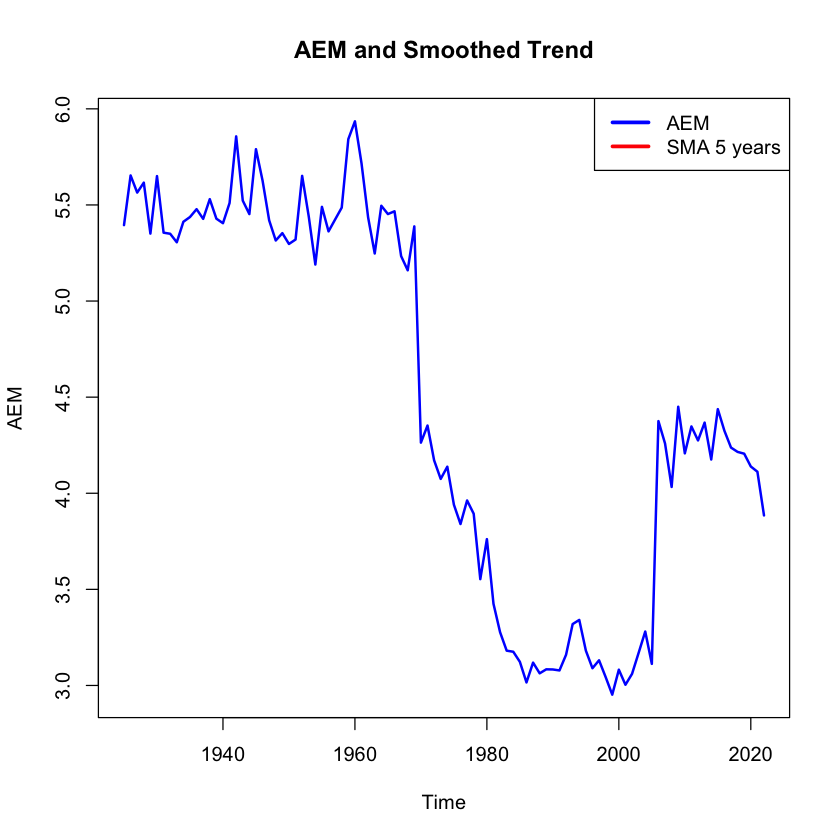

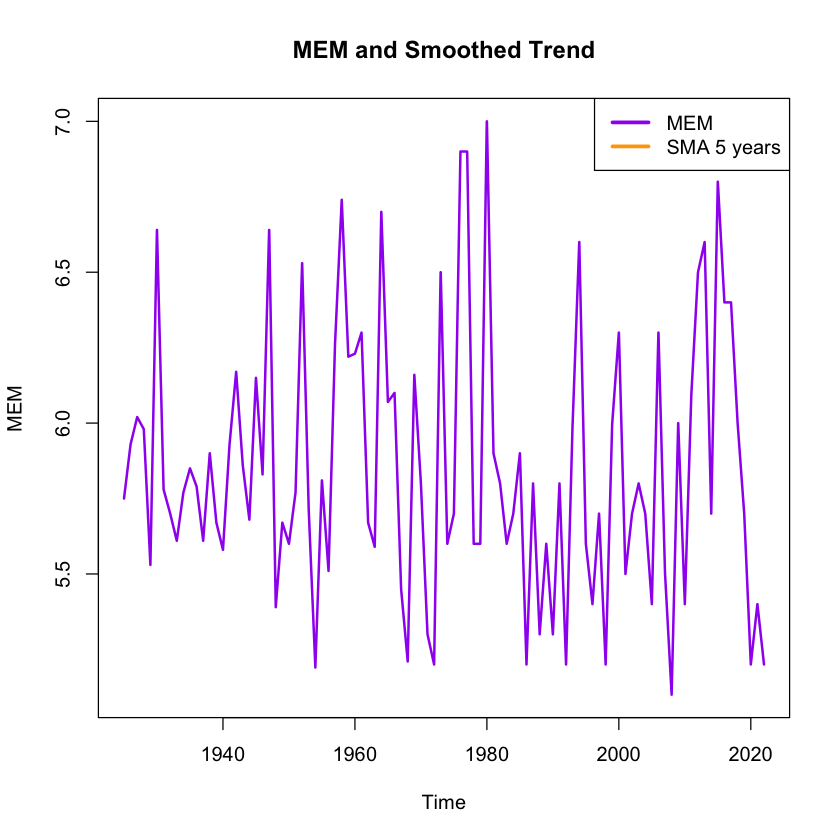

In [62]:
# Plot AEM with SMA
plot(AEM_ts, type = "l", col = "blue", main = "AEM and Smoothed Trend", ylab = "AEM", lwd = 2)
#lines(AEM_SMA5, col = "red",lwd = 3)
legend("topright", legend = c("AEM", "SMA 5 years"), col = c("blue", "red"), lty = 1, lwd = 3)

# Plot MEM with SMA
plot(MEM_ts, type = "l", col = "purple", main = "MEM and Smoothed Trend", ylab = "MEM", lwd = 2)
#lines(MEM_SMA5, col = "orange", lwd = 3)
legend("topright", legend = c("MEM", "SMA 5 years"), col = c("purple", "orange"), lty = 1, lwd = 3)

## ARIMA Model (autoregressive integrated moving average)

Non-seasonal ARIMA models are usually denoted ARIMA(p, d, q) where parameters p, d, q are non-negative integers: p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p, d, q)(P, D, Q)m, where the uppercase P, D, Q are the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model and m is the number of periods in each season.[8][2] When two of the parameters are 0, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym. For example, ⁠
ARIMA
(
1
,
0
,
0
)
{\displaystyle {\text{ARIMA}}(1,0,0)}⁠ is AR(1), ⁠
ARIMA
(
0
,
1
,
0
)
{\displaystyle {\text{ARIMA}}(0,1,0)}⁠ is I(1), and ⁠
ARIMA
(
0
,
0
,
1
)
{\displaystyle {\text{ARIMA}}(0,0,1)}⁠ is MA(1).  

Some well-known special cases arise naturally or are mathematically equivalent to other popular forecasting models. For example:  
ARIMA(0, 0, 0) models white noise.  
An ARIMA(0, 1, 0) model is a random walk.  
An ARIMA(0, 1, 2) model is a Damped Holt's model.  
An ARIMA(0, 1, 1) model without constant is a basic exponential smoothing model.[9]

In [26]:
# Fit ARIMA model for AEM
model_AEM <- auto.arima(AEM_ts)
summary(model_AEM)

Series: AEM_ts 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.2607
s.e.   0.0985

sigma^2 = 0.05443:  log likelihood = 4
AIC=-4.01   AICc=-3.88   BIC=1.14

Training set error measures:
                      ME      RMSE      MAE        MPE     MAPE     MASE
Training set -0.01886117 0.2309128 0.151895 -0.5779858 3.428184 0.959687
                    ACF1
Training set -0.02505676

In [ ]:
# Fit ARIMA model for MEM
model_MEM <- auto.arima(MEM_ts)
summary(model_MEM)

Series: MEM_ts 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      5.8537
s.e.  0.0450

sigma^2 = 0.2007:  log likelihood = -59.87
AIC=123.74   AICc=123.87   BIC=128.91

Training set error measures:
                        ME      RMSE      MAE        MPE     MAPE      MASE
Training set -1.499141e-14 0.4457472 0.354015 -0.5610463 5.991055 0.7670193
                  ACF1
Training set 0.1367273

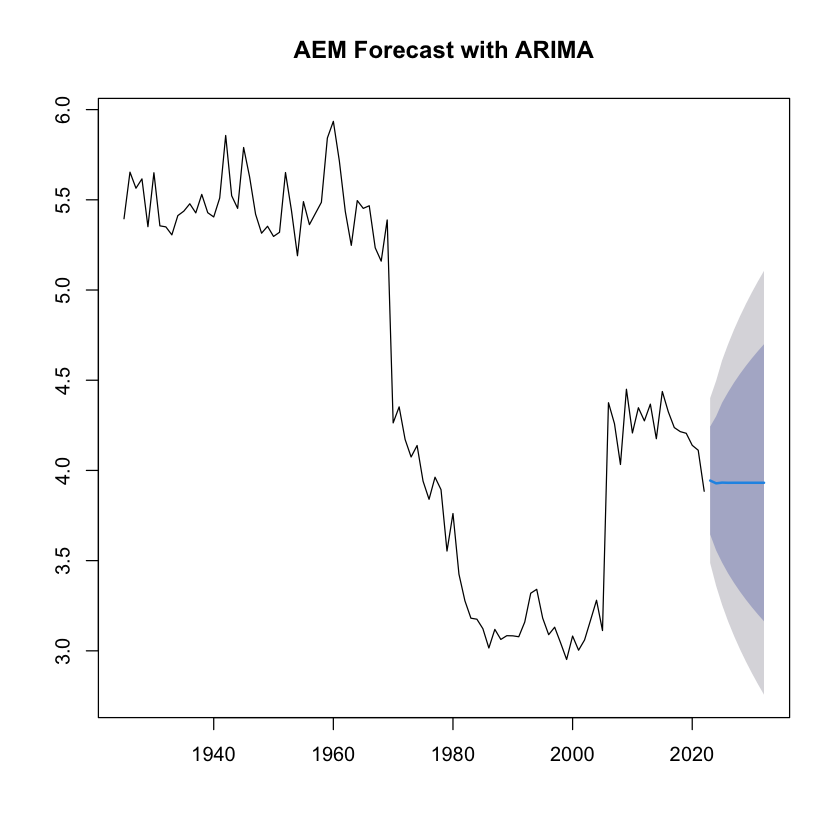

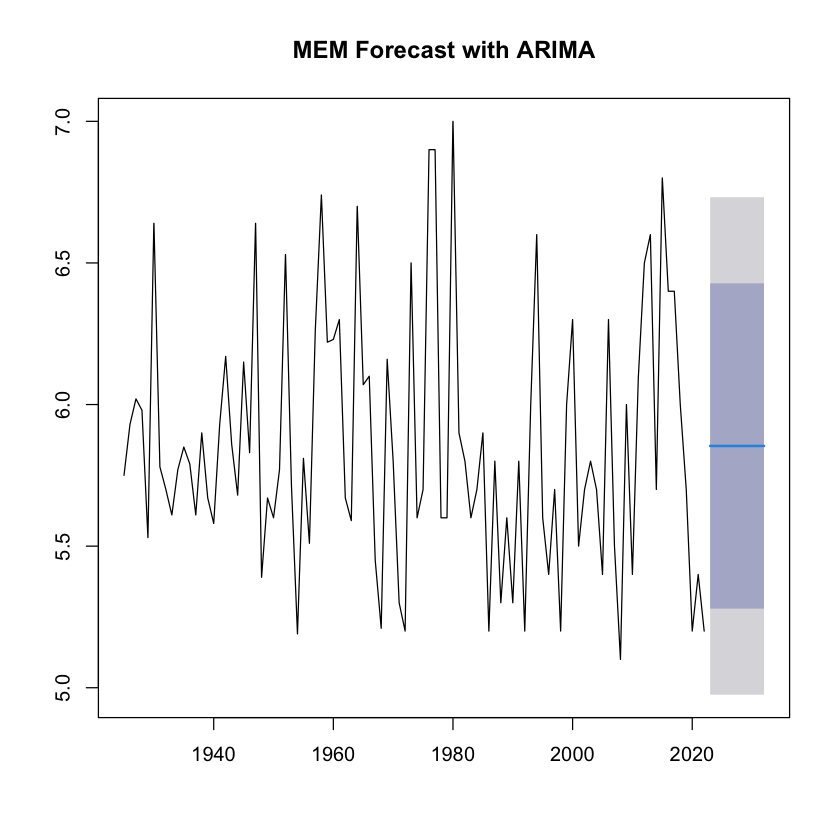

In [29]:
# Forecast next 10 years
forecast_AEM <- forecast(model_AEM, h = 10)

# Plot forecast
plot(forecast_AEM, main = "AEM Forecast with ARIMA")

# Forecast next 10 years
forecast_MEM <- forecast(model_MEM, h = 10)

# Plot forecast
plot(forecast_MEM, main = "MEM Forecast with ARIMA")


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 8.0661, df = 9, p-value = 0.5275

Model df: 1.   Total lags used: 10



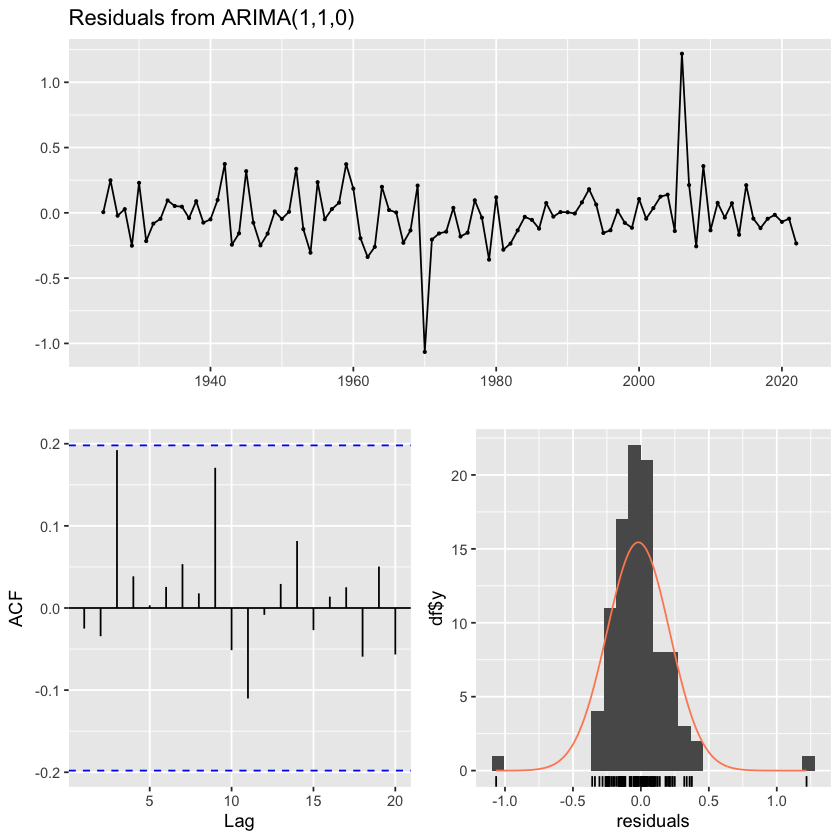


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 18.869, df = 10, p-value = 0.04196

Model df: 0.   Total lags used: 10



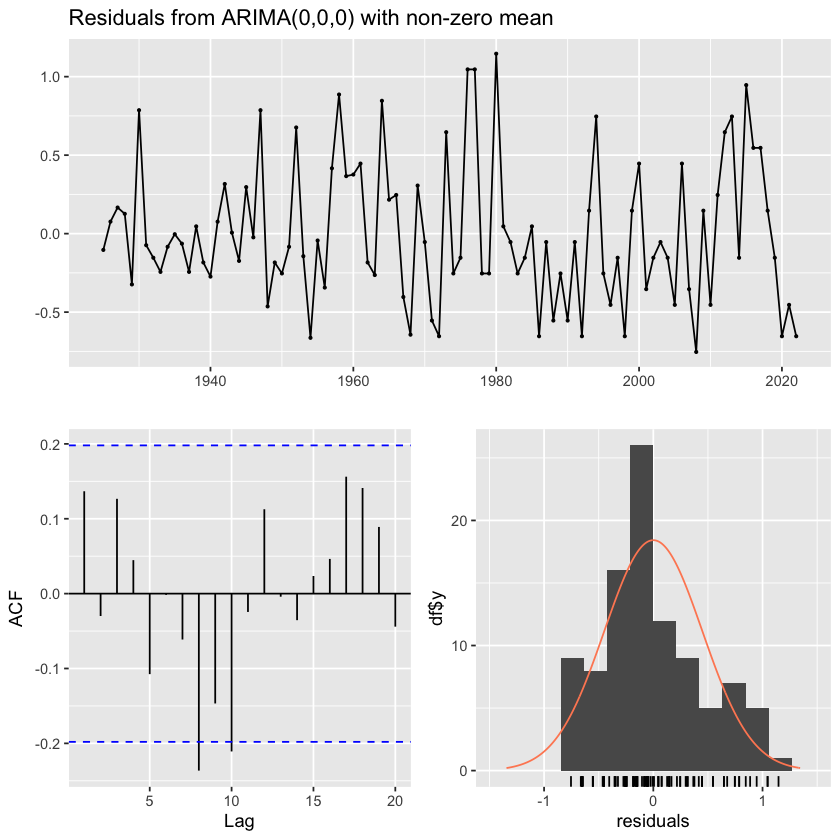

In [31]:
# AEM Residuals check
checkresiduals(model_AEM)

# MEM Residuals check
checkresiduals(model_MEM)

## SSA Model

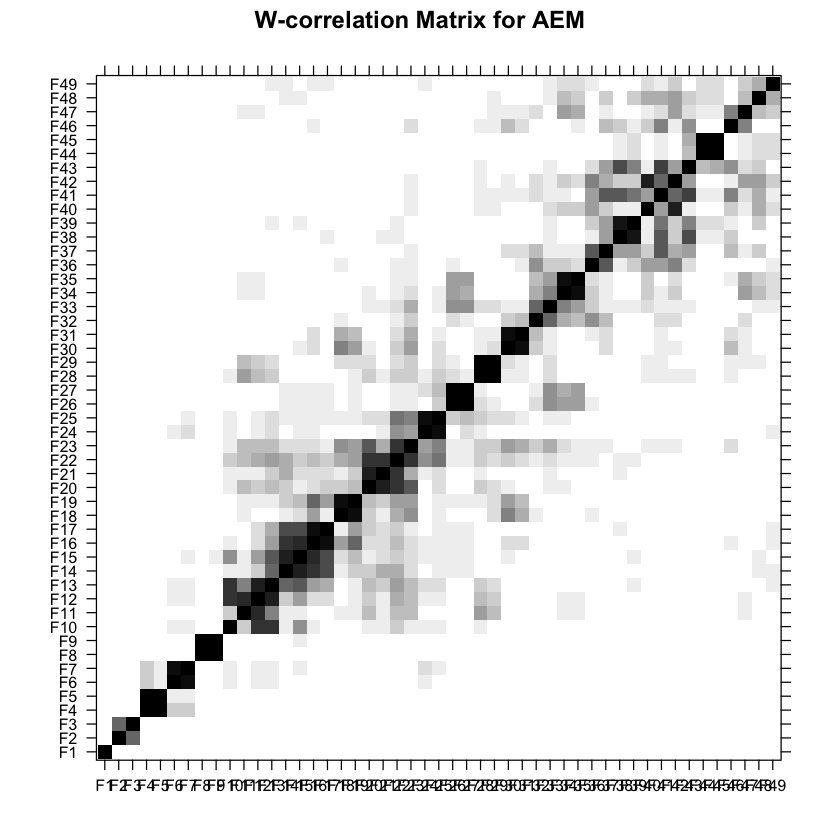

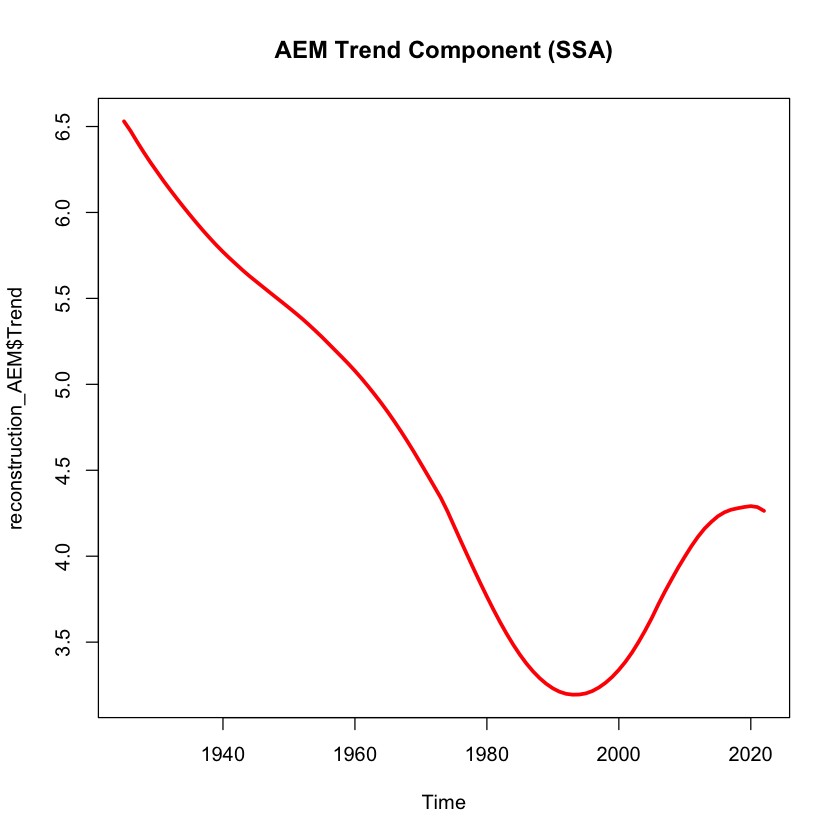

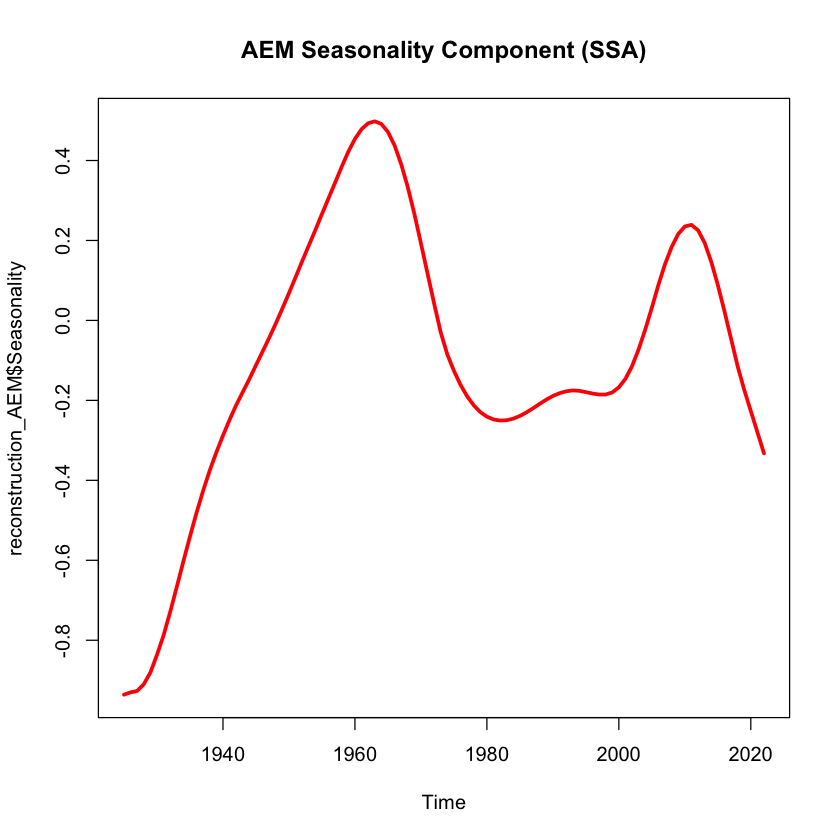

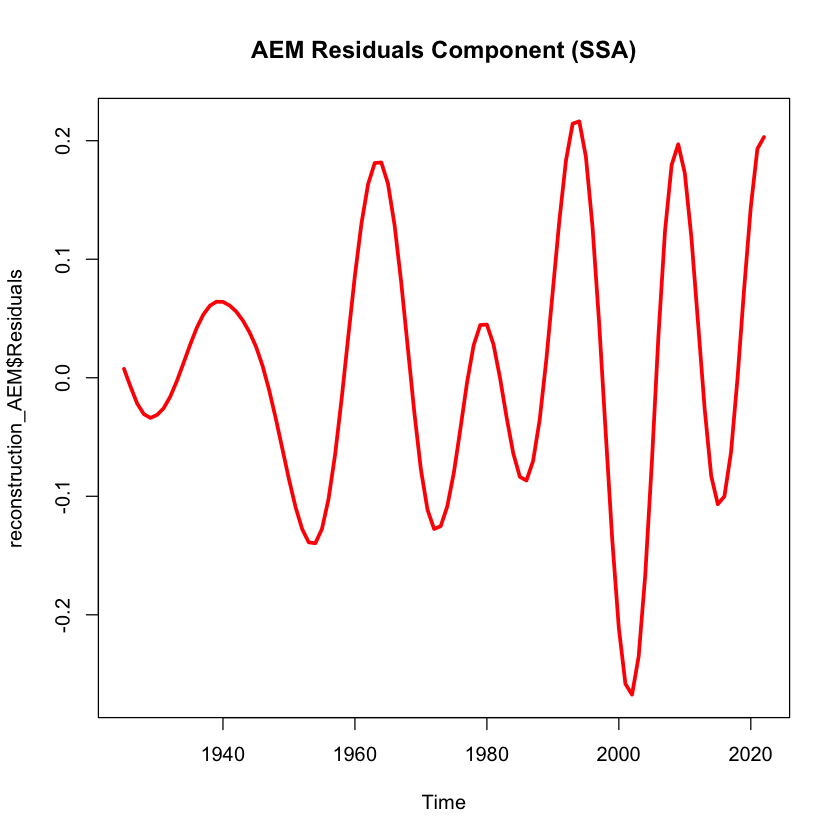

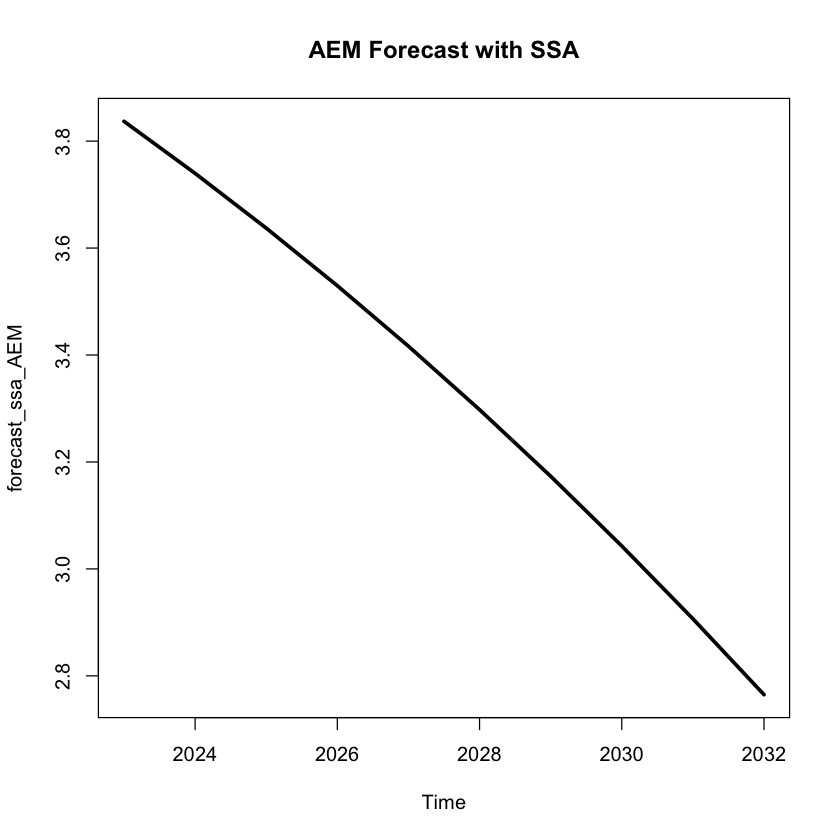

In [75]:
# Apply SSA to the AEM time series
ssa_AEM <- ssa(AEM_ts)
# Number of components (eigenvalues)
#length(ssa_AEM$values)
#nrow(yearly_data)
#summary(yearly_data$AEM)
#sum(is.na(yearly_data$AEM))
# Plot W-correlation matrix to analyze components relationship
plot(wcor(ssa_AEM), main = "W-correlation Matrix for AEM")

# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_AEM <- reconstruct(ssa_AEM, groups = list(Trend = 1:2, Seasonality = 3:4, Residuals = 5:length(ssa_AEM)))

#Plot the three component

plot(reconstruction_AEM$Trend, type = "l", col = "red", main = "AEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_AEM$Seasonality, type = "l", col = "red", main = "AEM Seasonality Component (SSA)", lwd = 3)
plot(reconstruction_AEM$Residuals, type = "l", col = "red", main = "AEM Residuals Component (SSA)", lwd = 3)

# Forecast next 10 years using SSA
forecast_ssa_AEM <- rforecast(ssa_AEM, groups = list(1:4), len = 10)

# Plot the forecast
plot(forecast_ssa_AEM, main = "AEM Forecast with SSA", lwd = 3)

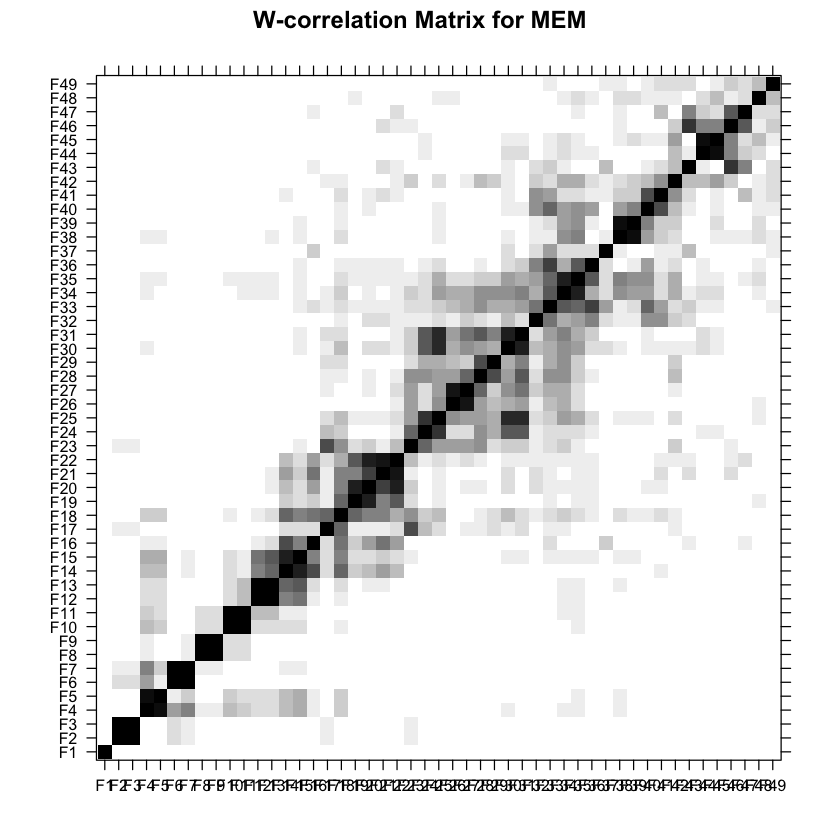

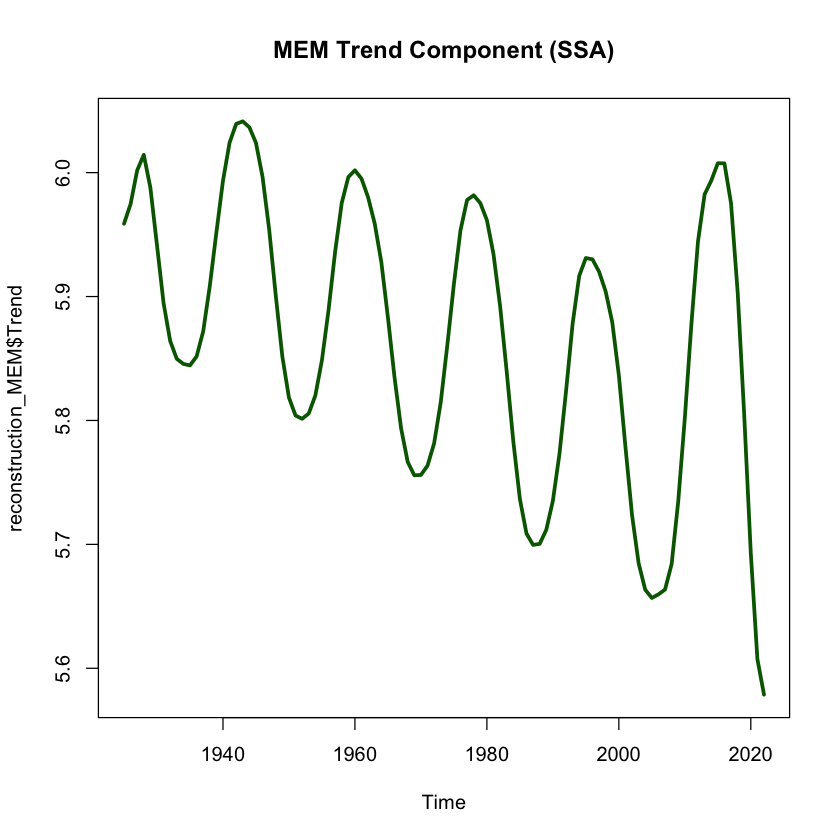

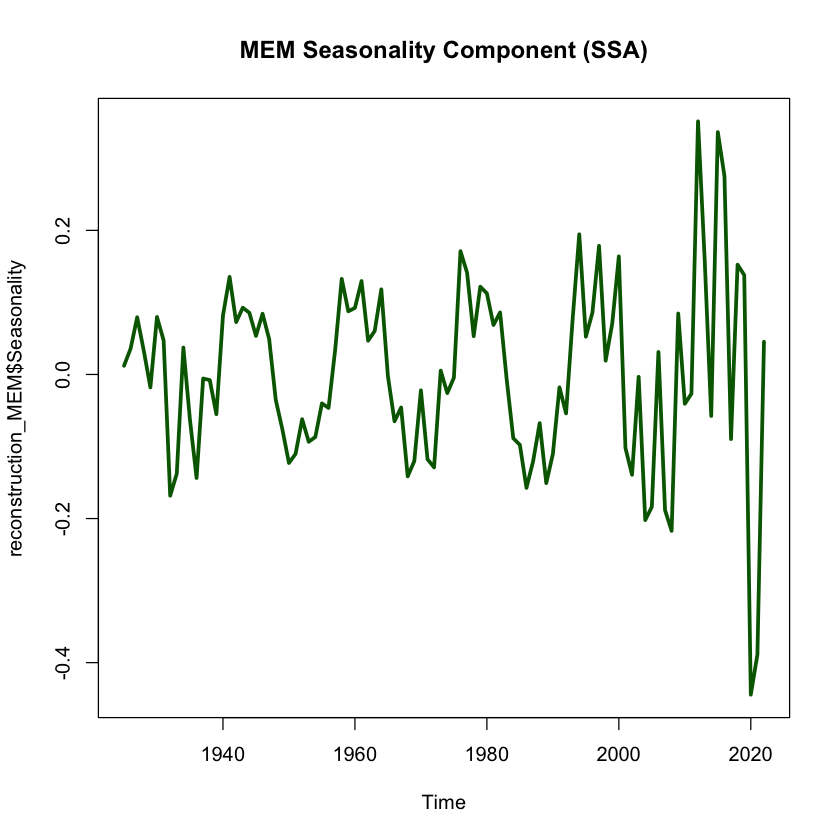

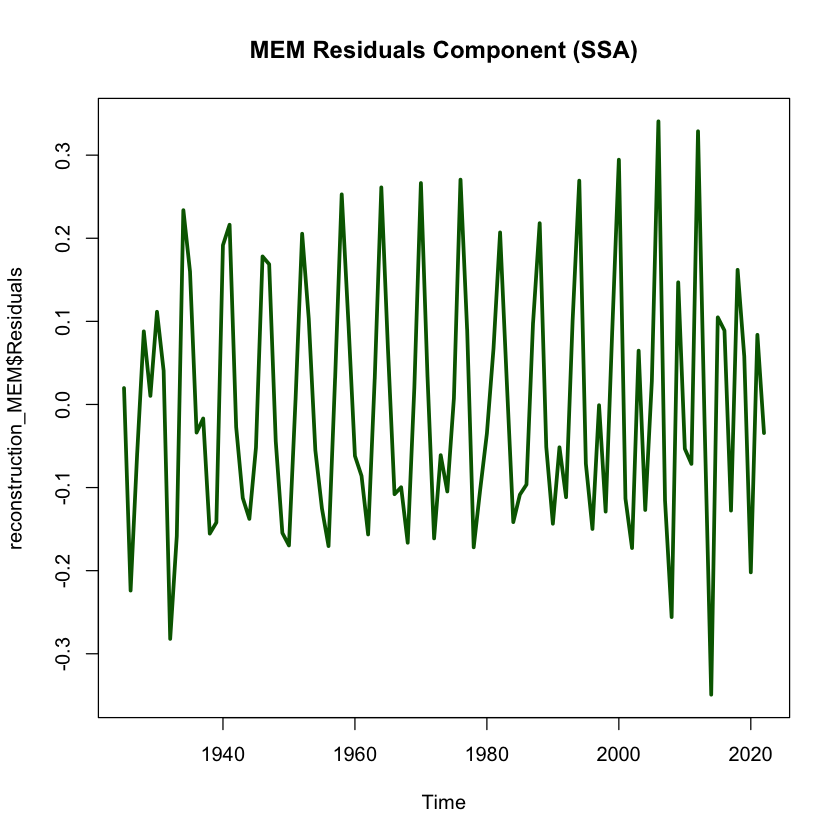

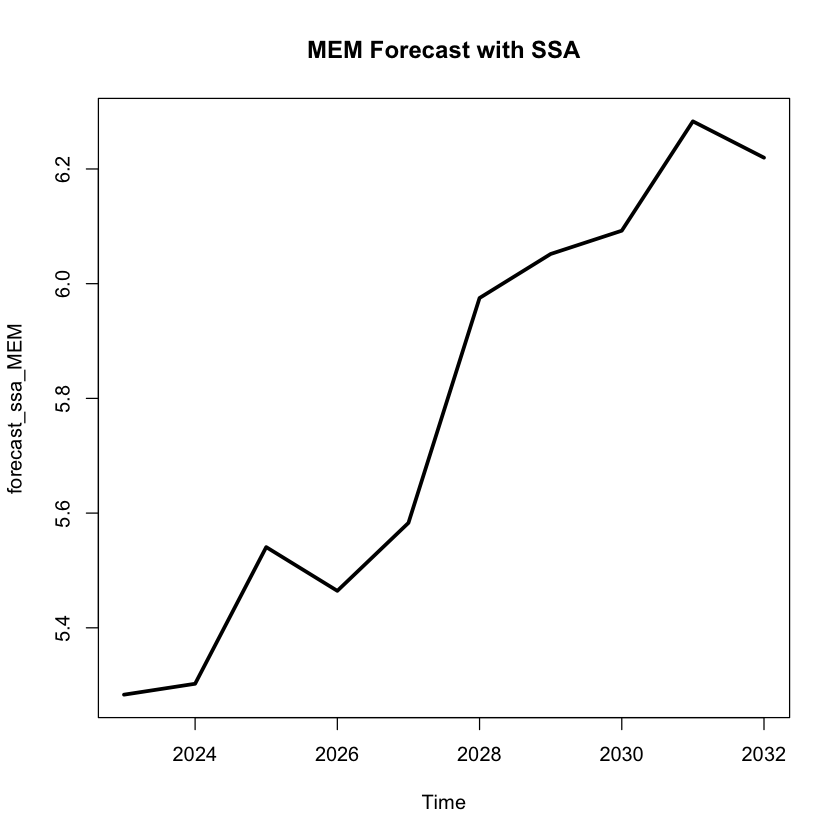

In [76]:
# Apply SSA to the MEM time series
ssa_MEM <- ssa(MEM_ts)

# Plot W-correlation matrix for MEM
plot(wcor(ssa_MEM), main = "W-correlation Matrix for MEM")

# Reconstruct main components: Trend, Seasonality, Residuals (Noise)
reconstruction_MEM <- reconstruct(ssa_MEM, groups = list(Trend = 1:2, Seasonality = 3:4, Residuals = 5:length(ssa_MEM)))

#Plot the three component

plot(reconstruction_MEM$Trend, type = "l", col = "darkgreen", main = "MEM Trend Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Seasonality, type = "l", col = "darkgreen", main = "MEM Seasonality Component (SSA)", lwd = 3)
plot(reconstruction_MEM$Residuals, type = "l", col = "darkgreen", main = "MEM Residuals Component (SSA)", lwd = 3)

# Forecast for MEM
forecast_ssa_MEM <- rforecast(ssa_MEM, groups = list(1:4), len = 10)
plot(forecast_ssa_MEM, main = "MEM Forecast with SSA" , lwd = 3)